In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

import consts as CONSTS
import utils as UTILS
import hydronet as NET
import datamanager as DataManager

I:\Anaconda3\envs\hhx\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
I:\Anaconda3\envs\hhx\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
I:\Anaconda3\envs\hhx\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# load data
train_test_ratio = 0.8
train_set = DataManager.HydroDataset('norm_data.npy', is_training=True, train_test_ratio=train_test_ratio)
test_set = DataManager.HydroDataset('norm_data.npy', is_training=False, train_test_ratio=train_test_ratio)

In [3]:
input, output = test_set[0]

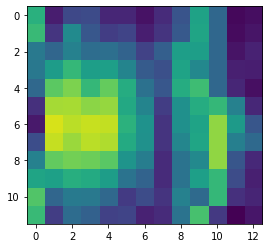

In [7]:
plt.imshow(input, vmin=0, vmax=1)

In [10]:
def load_model(dict_path):
    net = NET.HydroNetCNNLSTMAM(input_channel=13, conv_channel=32, conv_filter_sizes=[1,3], lstm_hidden_channel=32, lstm_layers=2, bidirectional=True)
    net.load_state_dict(
        torch.load(dict_path, map_location=torch.device('cpu'))
    )
    return net

In [19]:
model_dict_path = 'net_dict/net_dict_best.pth'
net = load_model(model_dict_path)

In [14]:
hidden_channels = 12
lstm_layers = 3
num_directions = 2
test_bilstm = nn.LSTM(6, hidden_channels, lstm_layers, batch_first=True, bidirectional=True)
with torch.no_grad():
    # test_bilstm.weight_hh_l0_reverse += 1
    test_bilstm.weight_hh_l1_reverse += 1
    # test_bilstm.bias_hh_l0_reverse += 1
    test_bilstm.bias_hh_l1_reverse += 1
    # test_bilstm.weight_ih_l0_reverse += 1
    test_bilstm.weight_ih_l1_reverse += 1
    # test_bilstm.bias_ih_l0_reverse += 1
    test_bilstm.bias_ih_l1_reverse += 1

In [20]:
input = torch.rand(1, 7, 6)
# input[:,3:,:] = 1

In [21]:
with torch.no_grad():
    output, (hn, cn) = test_bilstm(input)

In [22]:
output.shape, hn.shape, cn.shape

(torch.Size([1, 7, 24]), torch.Size([6, 1, 12]), torch.Size([6, 1, 12]))

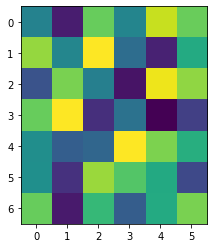

In [23]:
plt.imshow(input[0])

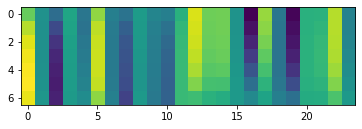

In [24]:
plt.imshow(output[0])

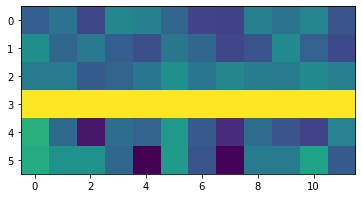

In [25]:
plt.imshow(hn[:,0])

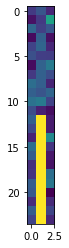

In [221]:
plt.imshow(hn.view(lstm_layers,-1,hidden_channels*num_directions).permute(1,0,2).transpose(1,2)[0])

In [222]:
aa = output
bb = hn.view(lstm_layers,-1,hidden_channels*num_directions).permute(1,0,2).transpose(1,2)

In [223]:
aa.shape, bb.shape, hn.shape

(torch.Size([1, 7, 24]), torch.Size([1, 24, 3]), torch.Size([6, 1, 12]))

In [224]:
torch.bmm(aa, bb).shape

torch.Size([1, 7, 3])

In [225]:
hidden = hn.permute(1,0,2).reshape(1,-1,lstm_layers)

In [226]:
hidden = hn.view(lstm_layers,-1,hidden_channels*num_directions).permute(1,0,2).transpose(1,2)

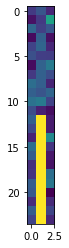

In [227]:
plt.imshow(hidden[0])

In [228]:
attn_weights = torch.bmm(output, hidden)

In [229]:
attn_weights.shape

torch.Size([1, 7, 3])

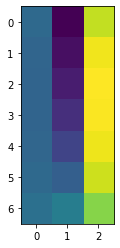

In [230]:
plt.imshow(attn_weights[0])

In [231]:
soft_attn_weights = F.softmax(attn_weights, 1)

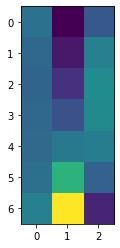

In [232]:
plt.imshow(soft_attn_weights[0])

In [233]:
context = torch.bmm(output.transpose(1, 2), soft_attn_weights)

In [234]:
context.shape

torch.Size([1, 24, 3])

In [ ]:
def attention_net(self, output, hn):
    hidden = hn.permute(1,0,2).reshape(1,-1,lstm_layers)
    hidden = hn.view(lstm_layers,-1,hidden_channels*num_directions).permute(1,0,2).transpose(1,2)
    attn_weights = torch.bmm(output, hidden)
    soft_attn_weights = F.softmax(attn_weights, 1)
    context = torch.bmm(output.transpose(1, 2), soft_attn_weights)
    return context

In [33]:
rec = torch.load('performance/rec_model=cla_logr=90_loss=msee.pth')

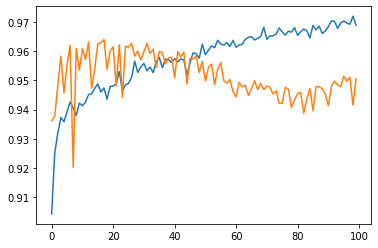

In [34]:
plt.plot(rec[:,1])
plt.plot(rec[:,3])

In [26]:
foo = torch.tensor([0.0780, 0.1375, 0.1090, 0.0645, 0.0255, 0.1160, 0.1845, 0.0685, 0.0480,
        0.0110, 0.0425, 0.0445, 0.0640, 0.0990, 0.0800, 0.1705, 0.0905, 0.2240,
        0.2100, 0.0905, 0.0750, 0.0635, 0.0515, 0.0395, 0.0585, 0.0910, 0.0865,
        0.0785, 0.0645, 0.3460, 0.0750, 0.0745, 0.0855, 0.0670, 0.0535, 0.0505,
        0.0655, 0.1020, 0.0730, 0.0385, 0.0865, 0.1575, 0.1285, 0.0720, 0.1445,
        0.1095, 0.0835, 0.0600, 0.0955, 0.0985, 0.0820, 0.0595, 0.0420, 0.1530,
        0.2300, 0.1535, 0.1730, 0.0960, 0.0685, 0.0605, 0.0850, 0.0990, 0.0820,
        0.0915, 0.1825, 0.2085, 0.1260, 0.0860, 0.0725, 0.0695, 0.0585, 0.0535,
        0.0865, 0.0955, 0.0775, 0.0570, 0.0620, 0.1395, 0.3980, 0.3915, 0.6900,
        0.1955, 0.1160, 0.0645, 0.0590, 0.0620, 0.0155, 0.0300, 0.0305, 0.0630,
        0.2080, 0.0855, 0.0725, 0.0665, 0.0220, 0.0345])

In [27]:
bar = torch.tensor([0.0409, 0.0545, 0.0909, 0.0810, 0.0668, 0.0666, 0.1513, 0.1717, 0.1431,
        0.0869, 0.0553, 0.0384, 0.0318, 0.0410, 0.0720, 0.0616, 0.0630, 0.0865,
        0.1940, 0.2108, 0.1846, 0.0884, 0.0690, 0.0483, 0.0500, 0.0713, 0.0921,
        0.0739, 0.0778, 0.0939, 0.2089, 0.2064, 0.1734, 0.1100, 0.0678, 0.0459,
        0.0404, 0.0531, 0.0872, 0.0547, 0.0464, 0.0477, 0.1461, 0.1532, 0.1231,
        0.0721, 0.0435, 0.0266, 0.0245, 0.0338, 0.0626, 0.0445, 0.0485, 0.0560,
        0.1654, 0.1697, 0.1476, 0.1278, 0.0624, 0.0391, 0.0375, 0.0530, 0.0737,
        0.0591, 0.0560, 0.0804, 0.1559, 0.1754, 0.1237, 0.0756, 0.0533, 0.0369,
        0.0380, 0.0540, 0.0767, 0.0691, 0.0644, 0.0765, 0.1821, 0.1847, 0.1747,
        0.1565, 0.1409, 0.0580, 0.0405, 0.0459, 0.0563, 0.0390, 0.0266, 0.0331,
        0.0996, 0.1177, 0.1174, 0.0624, 0.0386, 0.0211])

In [30]:
torch.abs((bar - foo)).mean()

tensor(0.0519)